Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=19260">[CSC2S004EP - 2024] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 3: Logistic Regression and k-Nearest Neighbors
</a>

Jérémie DECOCK - Adrien EHRHARDT

# Objectives

- Implement Logistic Regression and *k-Nearest Neighbor(s)*
- Use it to solve classification (and regression) problems
- Recognize and understand the aspects, strengths, and weaknesses of these algorithms

# Imports and tool functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import sklearn.neighbors
import sklearn.linear_model
from sklearn.utils import shuffle
from scipy.spatial import Voronoi, voronoi_plot_2d

Similar to the previous lab, we make a few helper functions to generate synthetic data.

In [2]:
def gen_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov = np.diag([1.5, 1.5])

    x1 = np.random.multivariate_normal(mean=[-1., -1.], cov=cov, size=n_samples)
    y1 = np.zeros(n_samples)

    x2 = np.random.multivariate_normal(mean=[2., 0.], cov=2. * cov, size=n_samples)
    y2 = np.ones(n_samples)

    x3 = np.random.multivariate_normal(mean=[-2., 2.], cov=cov, size=3 * n_samples)
    y3 = np.full(3 * n_samples, 2, dtype=int)

    if nclass == 3:
        X = np.concatenate([x1, x2, x3])
        y = np.concatenate([y1, y2, y3])
    elif nclass == 2:
        X = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

In [3]:
def gen_and_plot_1d_regression_samples(n_samples : int = 40):
    """
    Generates 1-dimensional regression samples

    :param int n_samples: number of samples to draw
    :returns: dataframe containing X (1 coordinate x) and y
    """
    x = np.random.uniform(low=-10., high=10., size=n_samples)
    y = x - 2. + np.random.normal(scale=3.5, size=x.shape)
    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])
    df.plot.scatter(x='x', y='y');
    return df

In [4]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_2d_classification_samples(dataframe: pd.DataFrame, model=None,
                                   voronoi: bool = False):
    """
    Plots the 2D classification problem, possibly with the results of a given model and the Voronoi cells.
    """
    plt.figure(figsize=(8, 8))
    df = dataframe  # make an alias so as not to modify dataframe
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x1', 'x2', 'y']"
    assert df.columns.values.tolist() == ['x1', 'x2', 'y'], ERROR_MSG1
    
    ERROR_MSG2 = "The `dataframe` parameter should be a Pandas DataFrame having the following labels (in column 'y'): [0, 1, 2]"
    labels = pd.unique(df.y).tolist()
    labels.sort()
    assert labels == list(range(3)) or labels == list(range(2)), ERROR_MSG2

    if model is not None:
        if voronoi:
            # Compute the Voronoi cells            
            vor = Voronoi(df[['x1', 'x2']])

            # Plot the Voronoi diagram
            fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False);
            fig.set_size_inches(8, 8);
        
        # Compute the model's decision boundaries
        h = .02  # step size in the mesh
        x_min, x_max = df.x1.min() - 1, df.x1.max() + 1
        y_min, y_max = df.x2.min() - 1, df.x2.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the model's decision boundaries
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.5, shading="auto")

    # Plot also the training points
    plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_bold, edgecolor='k', s=30)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", fontsize=16)

# Logistic Regression (with Gradient Descent)

Logistic regression is a **parametric binary classification algorithm**, so we generate a dataframe `df` containing a label `y` with only 2 classes (`0` and `1`).

In [5]:
df = gen_2d_classification_samples(n_samples = 100, nclass = 2)

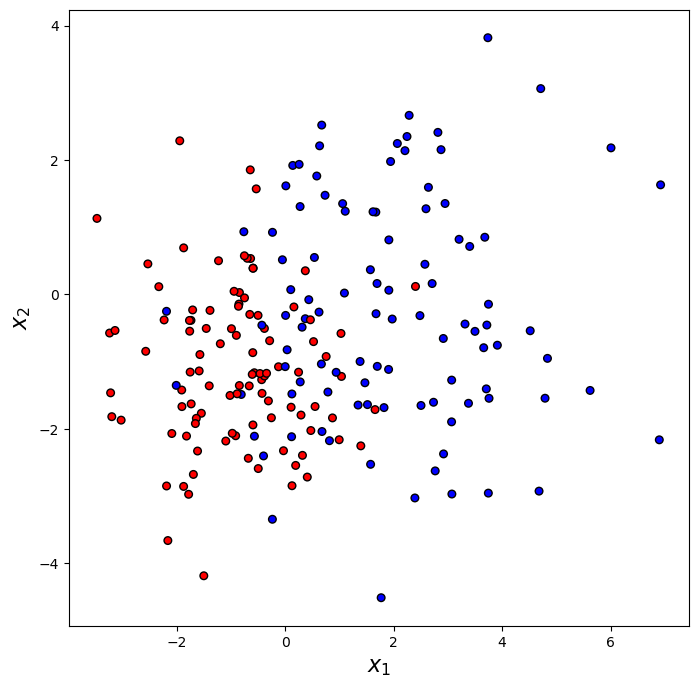

In [6]:
plot_2d_classification_samples(df)

Recall from last lab and lecture that to estimate a bias (also called intercept) term $\theta_0$, we have to add a column of 1s to the design matrix $X$.

In [7]:
X = np.array([np.ones((df.shape[0])), df.x1, df.x2]).T
y = np.array(df.y)
print("First 10 rows/samples")
print(X[:10, :])
print("With their respective labels")
print(y[:10])

First 10 rows/samples
[[ 1.          0.81501039 -2.17696026]
 [ 1.         -0.85428166 -0.14409854]
 [ 1.          3.66011132 -0.7935752 ]
 [ 1.          0.62252144 -0.26342543]
 [ 1.          3.74594959 -2.95703433]
 [ 1.         -2.33255016  0.11496664]
 [ 1.          0.6721993   2.51935042]
 [ 1.          2.73450204 -1.60502583]
 [ 1.         -1.5027352  -4.18706823]
 [ 1.          2.94752047  1.35268211]]
With their respective labels
[1. 0. 1. 1. 1. 0. 1. 1. 0. 1.]


Logistic regression is very similar to linear regression in so far as it is a **parametric model** which aims at finding a parameter $\boldsymbol{\theta}^\star$ such as $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ provides a good "link" between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \{0,1\}$ in a *training set* $\mathcal{D} = \{(\boldsymbol{x}^{(i)}, y^{(i)})\}_{1 \leq i \leq n}$ of $n$ examples:

$$
\boldsymbol{\theta}^\star = \arg\!\min_\boldsymbol{\theta} E(\boldsymbol{\theta}, \mathcal{D}),
$$

where $E(\boldsymbol{\theta}, \mathcal{D}) = - \sum_{i=1}^n \ln p_{\boldsymbol{\theta}}(y^{(i)} | \boldsymbol{x}^{(i)})$.

This is called the **log loss** (machine learning community), or the negative loglikelihood (statistics community).

Logistic regression is a rather simple model which states:

$$
p_{\boldsymbol{\theta}}(1 | \boldsymbol{x}^{(i)}) = \frac{1}{1+\exp{(-\boldsymbol{\theta}^T \boldsymbol{x}^{(i)})}}
$$

The loss function $E(\boldsymbol{\theta}, \mathcal{D})$ is convex, which means $\boldsymbol{\theta}^\star$ exists, is unique, and can be obtained by minimizing $E$.

## Exercise 1

Complete the following `gradient_descent` function implemented in the last lab to work for logistic regression. 

**Hint**: only the gradient needs to be changed.

In [8]:
def gradient_descent(X, y, eta=0.001, max_iteration=10000, initial_theta=np.random.normal(loc=0, scale=10, size=[3, 1])):
    theta = np.copy(initial_theta)
    grad_list = []      # Keep the gradient of all iterations
    theta_list = []     # Keep the solution of all iterations

    for t in range(max_iteration):
        # Perform the gradient descent here
        # Warning: grad and theta are vectors but 2 dimensional (p, 1)
        # For proper display, append 1D arrays or lists of size p to {grad,theta}list
        # YOUR CODE HERE
        z = np.dot(X, theta)
        p = 1 / (1 + np.exp(-z))
        error = p - y.reshape(-1, 1) 

        grad = np.dot(X.T, error)    
        theta = theta - eta * grad

        grad_list.append(grad.flatten())
        theta_list.append(theta.flatten())

    return grad_list, theta_list

(You don't have to fill in anything in the following cell; it's a general comment about the solution of the previous cell which will be provided in the solutions of this lab session.)

As a side note, we could have divided the gradient `grad` by `n` (the number of samples). It's merely some kind of convention: 

- If you divide by n, you have the mean-sample loss, so if you are generating data, you will converge as fast / slow (keeping eta constant) regardless of the number of samples you have, which in a way seems "consistent".

- If you don't, you use the total loss to update the parameters, so it's also arguably "logic" to converge faster with a constant eta, since you have more information.

For example, scikit lets you choose (normalize option): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

And by the way, for logistic regression, the "optimal" learning rate, which would be Newton Raphson's method (https://thelaziestprogrammer.com/sharrington/math-of-machine-learning/solving-logreg-newtons-method), is somehow also linked to the number of samples.

In [9]:
grad_list, theta_list = gradient_descent(X, y, eta = 0.0002)

You may play around back and forth with the "learning rate" $\eta$ (keyword argument $\texttt{eta}$) and display the successive values of the parameters.

In [10]:
# modify eta - and optionally max_iteration - and rerun graph below
grad_list, theta_list = gradient_descent(X, y, max_iteration=10000, eta=0.0002)

Let's see if it has converged by plotting the parameters w.r.t. the iteration number:

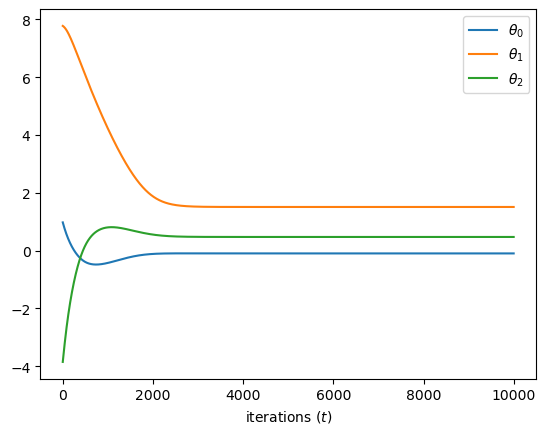

In [11]:
plt.plot([theta[0] for theta in theta_list], label=r"$\theta_0$");
plt.plot([theta[1] for theta in theta_list], label=r"$\theta_1$");
plt.plot([theta[2] for theta in theta_list], label=r"$\theta_2$");
plt.xlabel('iterations ($t$)')
plt.legend();

Let's see the decision boundary, i.e. the half-spaces where each label is predicted.

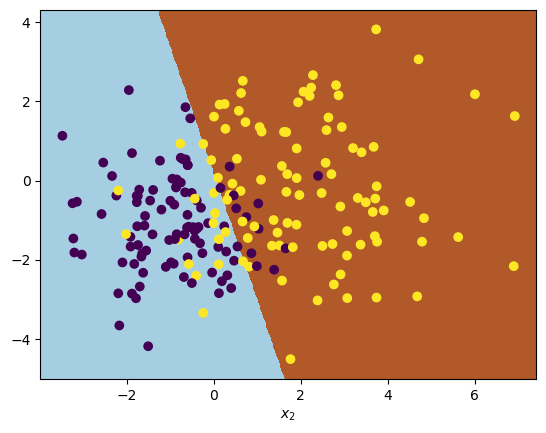

In [12]:
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = 1 / (1 + np.exp(-np.dot(np.c_[np.ones((len(xx.ravel()))),
                                  xx.ravel(), yy.ravel()], theta_list[9999])))
plt.pcolormesh(xx, yy, (Z.reshape(xx.shape) > 0.5)*1, cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.xlabel('$x_2$')
plt.scatter(df.x1, df.x2, c=y);

# Logistic Regression (scikit-learn)

## Exercise 2

Let's do the same using scikit-learn!

Similar to the previous lab, logistic regression belongs to the linear model module, and provides among others the `fit` and `predict` methods. Use the `fit` method to perform gradient descent under the hood, and then compare the coefficients obtained with scikit-learn and your gradient descent.

Note that we disable the `penalty` term for now - as that is a topic we deal with next week.

Note that we don't use $X$ but `df[['x1', 'x2']]`: recall from last lab that sklearn is smart enough to add the column of 1s under the hood (with the default `fit_intercept=True` argument).

In [13]:
# Uncomment model.fit(...) and provide the appropriate parameters)
model = sklearn.linear_model.LogisticRegression(penalty=None)
model.fit(df[['x1', 'x2']], df['y'])
# YOUR CODE HERE
#plot_2d_classification_samples(df)

LogisticRegression(penalty=None)

Let's see if we came up with the same estimates:

In [14]:
print("Intercept")
print("=========")
print("sklearn:\t\t", model.intercept_[0])
print("gradient descent: \t", theta_list[-1][0])
print("\n")

print("theta_1")
print("=========")
print("sklearn:\t\t", model.coef_[0][0])
print("gradient descent:\t", theta_list[-1][1])
print("\n")

print("theta_2")
print("=========")
print("sklearn:\t\t", model.coef_[0][1])
print("gradient descent:\t", theta_list[-1][2])

Intercept
sklearn:		 -0.09711504182808264
gradient descent: 	 -0.096975201809966


theta_1
sklearn:		 1.509438431049869
gradient descent:	 1.5094701977264182


theta_2
sklearn:		 0.4723039777723483
gradient descent:	 0.47226345806390196


# Logistic Regression with Polynomial Basis Functions

We will now generate some data with a non-linear boundary between classes to illustrate the power of the logistic regression classifier with polynomial basis function features as input. 

In [15]:
def gen_nonlinear_2d_classification_samples(n_samples: int = 20, nclass: int = 3) -> pd.DataFrame:
    """
    Generates 2-dimensional samples which belong to either 2 or 3 classes

    :param int n_samples: number of samples to draw per class
    :param int nclass: number of classes the samples belong to (either 2 or 3)
    :returns: dataframe containing X (2 coordinates x1, x2) and y (as int!)
    """
    cov1 = np.diag([2., 2])
    cov2 = np.diag([6., 2])

    x1 = np.random.multivariate_normal(mean=[-2., 0.], cov=cov1, size=n_samples)
    y1 = np.zeros(n_samples)
    x2 = np.random.multivariate_normal(mean=[1., 5], cov=cov1, size=n_samples)
    y2 = np.zeros(n_samples)
    x3 = np.random.multivariate_normal(mean=[2., -4.], cov=cov1, size=n_samples)
    y3 = np.zeros(n_samples)

    x4 = np.random.multivariate_normal(mean=[3., 1.], cov=cov2, size=n_samples)
    y4 = np.ones(n_samples)

    if nclass == 2:
        X = np.concatenate([x1, x2, x3, x4])
        y = np.concatenate([y1, y2, y3, y4])
    else:
        raise ValueError("Only 2 or 3 classes")

    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y

    df = shuffle(df).reset_index(drop=True)
    
    return df

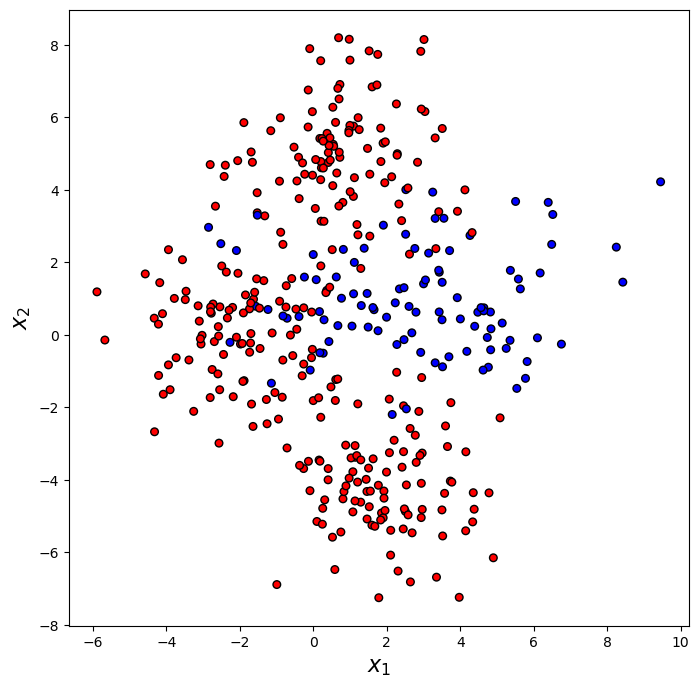

In [16]:
df = gen_nonlinear_2d_classification_samples(n_samples=100, nclass=2)
plot_2d_classification_samples(df)

## Exercise 3

Fit two logisic regression models.

The first model called `model_lin` should be fit to the data stored in `df`, corresponding to features $x_1, x_2$ stored in `df` (yes, this is similar to what we did in Exercise 2).

The second model called `model_sq` should be fit to a dataframe containing also entries corresponding to $\boldsymbol\phi = [x_1,x_2,x_1^2,x_2^2]^\top$, not forgetting about the intercept term.

Then, use the two models to predict the class of the center of the blue points (point (3, 1)) and store the predictions of `model_lin` and `model_sq` in `pred_lin` and `pred_sq`, respectively.

In [17]:
model_lin = sklearn.linear_model.LogisticRegression(penalty=None)
model_lin.fit(df[['x1', 'x2']].values, df['y'])

df['x1^2'] = df['x1'] ** 2
df['x2^2'] = df['x2'] ** 2

model_sq = sklearn.linear_model.LogisticRegression(penalty=None)
model_sq.fit(df[['x1', 'x2', 'x1^2', 'x2^2']].values, df['y'])

pred_lin = model_lin.predict([[3, 1]])
pred_sq = model_sq.predict([[3, 1, 9, 1]])

print(f"Prediction of the linear model:\t {pred_lin}")
print(f"Prediction of the quadratic model:\t {pred_sq}")

Prediction of the linear model:	 [0.]
Prediction of the quadratic model:	 [1.]


Run the below code cell to visualise the decision boundaries of `model_lin` and `model_sq`.

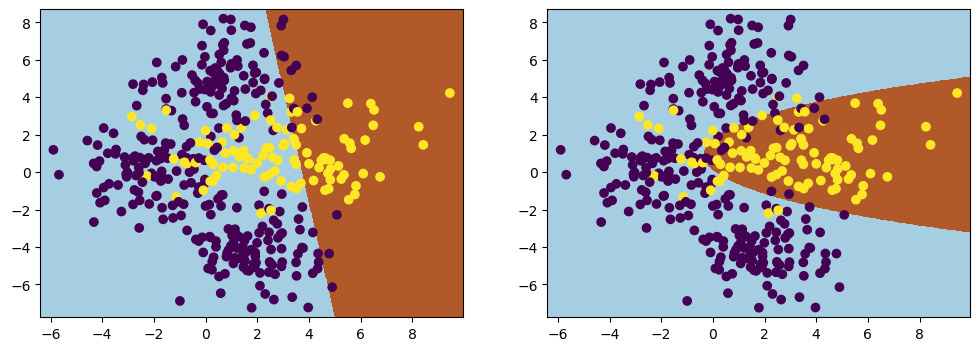

In [18]:
plt.figure(figsize=(12, 4))

# model_lin
plt.subplot(1, 2, 1)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_lin.predict(np.concatenate([
    xx.ravel().reshape((-1,1)),yy.ravel().reshape((-1,1))], axis=1)).reshape(xx.shape),
               cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

# model_sq
plt.subplot(1, 2, 2)
x_min, x_max = np.array((df.x1, df.x2))[0, :].min() - .5,\
    np.array((df.x1, df.x2))[0, :].max() + .5
y_min, y_max = np.array((df.x1, df.x2))[1, :].min() - .5,\
    np.array((df.x1, df.x2))[1, :].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.pcolormesh(xx, yy, model_sq.predict(np.concatenate([
    xx.ravel().reshape((-1, 1)),yy.ravel().reshape((-1, 1)),
    xx.ravel().reshape((-1, 1))**2, yy.ravel().reshape((-1, 1))**2],
    axis=1)).reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(df.x1, df.x2, c=df['y']);

# Nearest Neighbor algorithm

Here you will implement one of the simplest (but quite powerful) machine learning algorithm: the *Nearest Neighbor* algorithm and its extension, the *k-Nearest Neighbors* algorithm (or *kNN*). Both can be used for classification and regression tasks.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples, the *Nearest Neighbor* model assigns an input vector $\boldsymbol{x}$ (of dimension $p$) to the label $y_{{\arg\!\min}_{i=1,\dots, n}d(x, x_i)}$ of its closest neighbor in $\mathcal{D}$.

The closest neighbor is defined w.r.t. a distance function $d$. This can be any metric measure, but the *Minkowski distance* (especially the classical Euclidian distance $d_2$) is the most common choice. It is defined as follows:

$$d_q: \mathbb{R}^p \times \mathbb{R}^p \to \mathbb{R}$$

$$d_q(\boldsymbol{u}, \boldsymbol{v}) = ||\boldsymbol{u} - \boldsymbol{v}||_q = \left( \sum_{j=1}^p |u_j - v_j|^q \right)^{1/q}$$

When $q=2$, $d_q$ is the *Euclidian distance*

$$d_2(\boldsymbol{u}, \boldsymbol{v}) = \sqrt{\sum_{j=1}^{p} (u_j - v_j)^2}$$

When $q=1$, $d_q$ is the *Manhattan distance*

$$d_1(\boldsymbol{u}, \boldsymbol{v}) = \sum_{j=1}^{p} |u_j - v_j|$$

When $q=\infty$, $d_q$ is the  *Tchebychev distance*

$$d_{\infty}(\boldsymbol{u}, \boldsymbol{v}) = \max_{j=1,\dots,p} |u_j - v_j|$$

## Exercise 5

Consider this new dataset (where `volume (mL)` and `caffeine (g)` are the examples' features and where `drink` is their label):

In [19]:
data = [[250, 0.025, 'tea'],
        [100, 0.01,  'tea'],
        [125, 0.05,  'coffee'],
        [250, 0.1,   'coffee']]

df = pd.DataFrame(data, columns=['volume (mL)', 'caffeine (g)', 'drink'])
df

,volume (mL),caffeine (g),drink
0,250,0.025,tea
1,100,0.010,tea
2,125,0.050,coffee
3,250,0.100,coffee


### Exercise 5.1

Use the Nearest Neighbor method to predict the label of a 100mL drink having 0.075g of caffeine. Store the answer as a string in the variable `answer`.

N.B.: if you have some intuition about what applying kNN to this dataset would yield, just write the answer. In other words, you don't necessarily need to implement kNN to answer this question.

In [20]:
answer = 'tea'
# Provide some code to prove your answer.
# YOUR CODE HERE
print(answer)

tea


### Exercise 5.2

Think about: what is wrong with this prediction? How to solve this problem? (No answer expected).

# Nearest Neighbor method with Scikit Learn

Let's play with the Scikit Learn implementation of the Nearest Neighbor algorithm.
The official documentation is here: https://scikit-learn.org/stable/modules/neighbors.html

## Classification

We begin with a "toy" **classification problem**.

We use the `gen_2d_classification_samples()` function (defined above) to generate a dataset.

In [21]:
df = gen_2d_classification_samples(n_samples=20)
df.head()

,x1,x2,y
0,-1.218044,0.730876,2.0
1,0.235614,-1.677809,0.0
2,0.814424,-2.764317,1.0
3,2.375424,-1.606276,1.0
4,-1.135895,0.388383,2.0


Here, examples are defined in $\mathbb{R}^2$ (features are stored in columns `x1` and `x2`).
Examples' labels are defined in the `y` column. This is similar to Exercise 1.

The `y` column contains three possible labels: `1`, `2` and `3` respectively represented by the red, green and blue colors in the following figure.

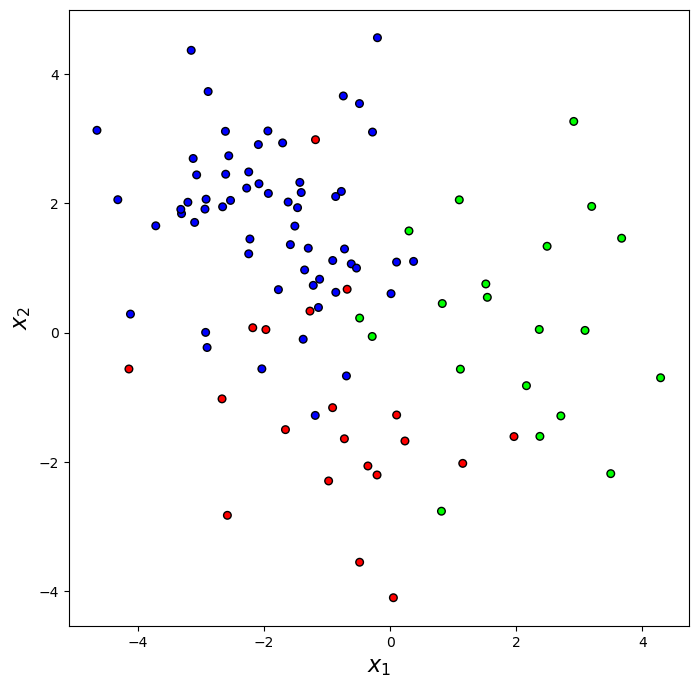

In [22]:
plot_2d_classification_samples(df)

Thus this toy problem is a multiclass classification problem.

Once the dataset is ready, let's make the classifier and train it with the following code:

In [23]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
# 1-NN as a special case of k-NN

In [24]:
model.fit(X=df[['x1', 'x2']].values, y=df['y'])

KNeighborsClassifier(n_neighbors=1)

## Exercise 6

### Exercise 6.1
Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2 \\ 0}, x_{p2} = \pmatrix{0 \\ 6}, x_{p3} = \pmatrix{8 \\ 0}$$

Store the result in `model_predictions`.

In [25]:
# model_predictions = ...
# YOUR CODE HERE
model_predictions = model.predict([[-2, 0], [0, 6], [8, 0]])
model_predictions

array([0., 2., 1.])

### Exercise 6.4
The next cell generates the *Voronoï diagram* of the dataset. The Voronoï diagram makes a partition of the feature space $\mathcal{X}$.
Each partition is a *cell*. Think about what each cells represents. 

<Figure size 800x800 with 0 Axes>

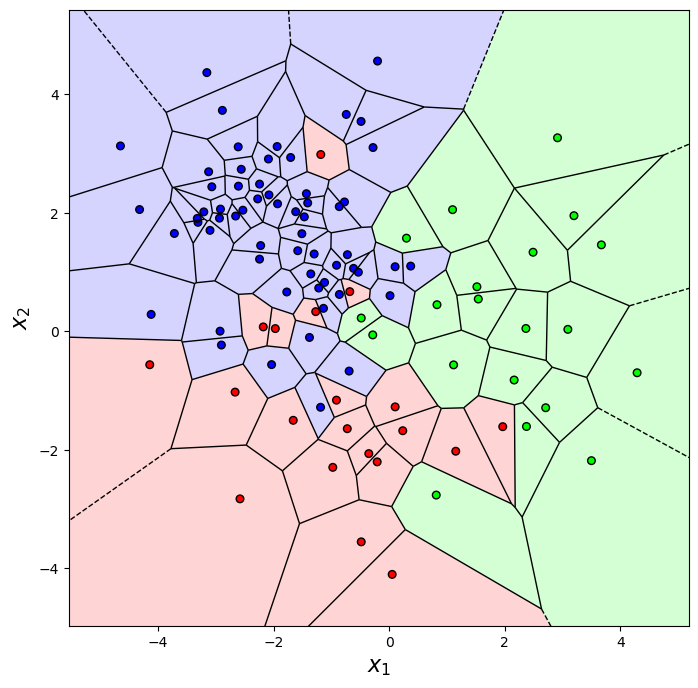

In [26]:
plot_2d_classification_samples(df, model=model, voronoi=True)

## Regression

After the "toy" classification problem, let's work on a toy **regression problem**.

The next cell generates a dataset (where 'x' is the feature and 'y' the label to predict).

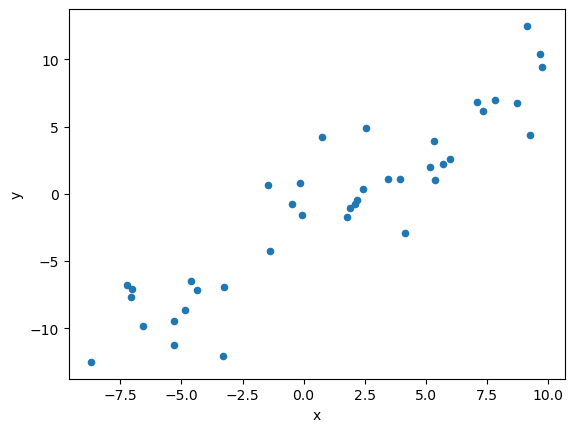

In [27]:
df = gen_and_plot_1d_regression_samples()

Once the dataset is ready, let's make the regressor and train it with the following code:

In [28]:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1)

In [29]:
model.fit(df[['x']].values, df['y'])

KNeighborsRegressor(n_neighbors=1)

## Exercise 7

### Exercise 7.1
Use the `model.predict()` function to classify the following points:

$$x_{p1} = \pmatrix{-5}, x_{p2} = \pmatrix{0}, x_{p3} = \pmatrix{5}$$

Store it in `model_predictions_bis`.

In [30]:
# model_predictions_bis = ...
# YOUR CODE HERE
predictions = pd.DataFrame({'x': [-5, 0, 5]})
model_predictions_bis = model.predict(predictions[['x']].values)
model_predictions_bis

array([-8.64070496, -1.54837183,  2.01579959])

Plot the model's decision function using the following cell.

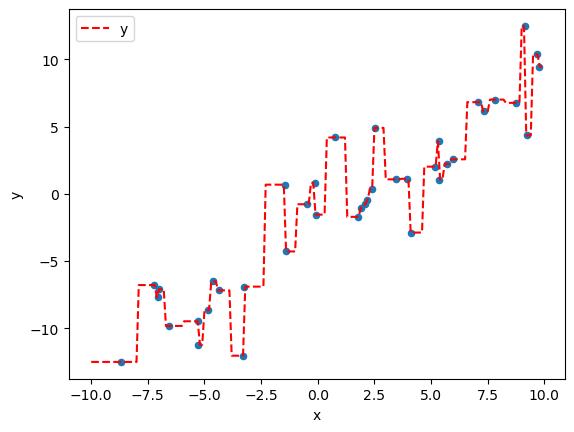

In [31]:
x_pred = np.arange(-10, 10, 0.1).reshape(-1, 1)
y_pred = model.predict(x_pred)

df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

ax = df.plot.scatter(x='x', y='y')
df_pred.plot(x='x', y='y', style='r--', ax=ax);

### Exercise 7.2

Do you think this model *generalizes* well?

By generalization, we mean performance on unseen - test - examples drawn from the same distribution as the seen - training - examples. Recall what happened with polynomial regression with a high degree. Why? (No answer expected)

# k-Nearest Neighbors algorithm

The *Nearest Neighbor* method is very sensitive to noise: if an example in $\mathcal{D}$ is wrongly labeled or positioned, all points in its Voronoï cell will be wrong too. The *k Neareast Neighbor* fix this weakness by considering for each prediction the label of several neighbors instead of just one.

Considering a dataset $\mathcal{D}=\{(\boldsymbol{x}_i, y_i)_{i=1,\dots,n}\}$ of $n$ labeled examples and a meta / hyper parameter $k \in \mathbb{N}*$, the *$k$ Nearest Neighbors* model assigns an input vector $\boldsymbol{x}$ to the label $y$ (defined below) of its $k$ closest neighbor in $\mathcal{D}$.
Let's write $\mathcal{N}_k(\boldsymbol{x})$ the set of the $k$ nearest neighbors of $\boldsymbol{x}$ in $\mathcal{D}$.

- For classification problems, the label assigned to $\boldsymbol{x}$ is the **most represented label** among the nearest neighbors (majority vote)
$$f(\boldsymbol{x}) = {\arg\!\max}_c \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} \delta(y_i, c)$$

- For regression problems, the label assigned to $\boldsymbol{x}$ is computed based on the **mean** of the labels of its nearest neighbors $\mathcal{N}_k(\boldsymbol{x})$
$$f(\boldsymbol{x}) = \frac{1}{k} \sum_{i: x_i \in \mathcal{N}_k(\boldsymbol{x})} y_i$$

## Exercise 8

We consider the following dataset (where `x1` and `x2` are the example features and where `y` is the example label):

In [32]:
data = [[1, 2, '+'],
        [2, 1, '+'],
        [2, 2, '-'],
        [2, 3, '+'],
        [1, 1, '-'],
        [3, 3, '+']]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df

,x1,x2,y
0,1,2,+
1,2,1,+
2,2,2,-
3,2,3,+
4,1,1,-
5,3,3,+


### Exercise 8.1
Draw this dataset (it is OK to draw it on a sheet of paper: empty the code cell, add a Markdown cell and upload your picture by drag-and-drop; you can also make use of `df.plot`).

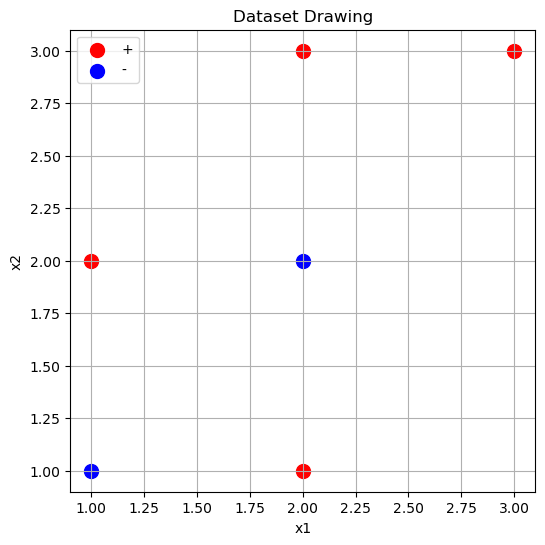

In [33]:
# YOUR CODE HERE
data = [[1, 2, "+" ],
        [2, 1, "+" ],
        [2, 2, "-" ],
        [2, 3, "+" ],
        [1, 1, "-" ],
        [3, 3, "+" ]]

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])

plt.figure(figsize=(6, 6))
colors = {'+': 'red', '-': 'blue'}
for label in df['y'].unique():
    subset = df[df['y'] == label]
    plt.scatter(subset['x1'], subset['x2'], c=colors[label], label=label, s=100)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Dataset Drawing')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 8.2
Draw the decision boundary of a Nearest Neighbor model (i.e. 1NN - also OK on a sheet of paper).

You may need to convert `y` to an integer type and make good use of `KNeighborsClassifier` (see Exercise 2). See also provided helper function `plot_2d_classification_samples`.

<Figure size 800x800 with 0 Axes>

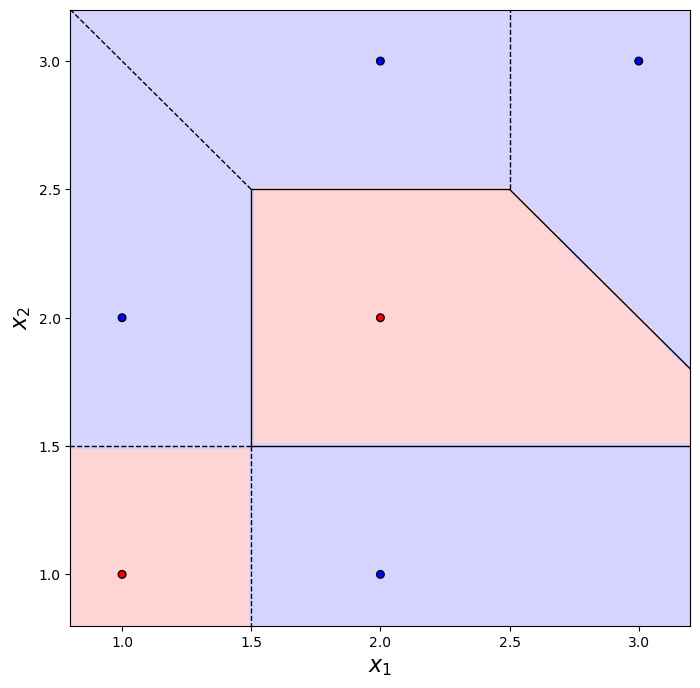

In [34]:
# Warning: if you're modifying df in place, you may need to rerun the previous cell to reload df while you debug the conversion of y
# YOUR CODE HERE
df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df['y'] = df['y'].map({'+' : 1, '-' : 0})
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
model.fit(df[['x1', 'x2']].values, df['y'])
plot_2d_classification_samples(df, model=model, voronoi=True)

### Exercise 8.3
Draw the decision boundary of a 3 Nearest Neighbor model (i.e. 3NN), either with code or on a sheet of paper.

*Hint:* The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

<Figure size 800x800 with 0 Axes>

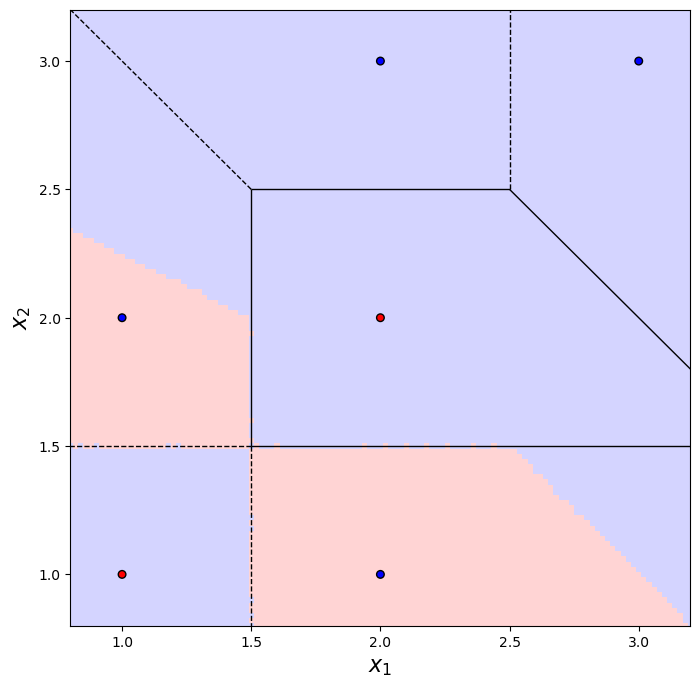

In [35]:
# YOUR CODE HERE
# Define the dataset
df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df['y'] = df['y'].map({'+' : 1, '-' : 0})
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
model.fit(df[['x1', 'x2']].values, df['y'])
plot_2d_classification_samples(df, model=model, voronoi=True)

# k-Nearest Neighbor (kNN) with Scikit Learn

## Classification

First we regenerate the dataset used throughout Exercise 3.

In [36]:
df = gen_2d_classification_samples()

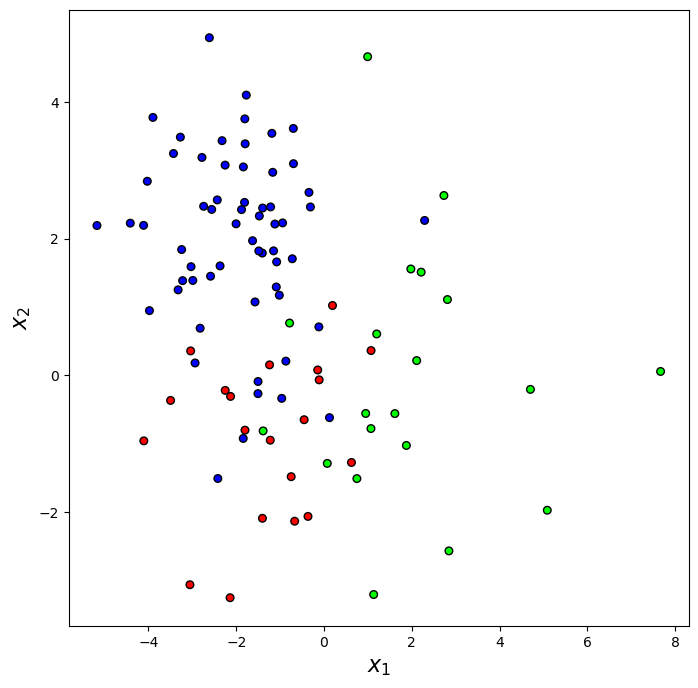

In [37]:
plot_2d_classification_samples(df)

Then we instantiate the classifier, train it and plot the decision boundaries:

In [38]:
def learn_knn_and_plot(**kwargs):
    """
    Learns a knn model and plot the points, their class and the decision boundaries

    :param kwargs: keyword arguments passed to KNeighborsClassifier
    """
    model = sklearn.neighbors.KNeighborsClassifier(**kwargs)
    model.fit(df[['x1', 'x2']].values, df['y'])
    plot_2d_classification_samples(df, model=model)

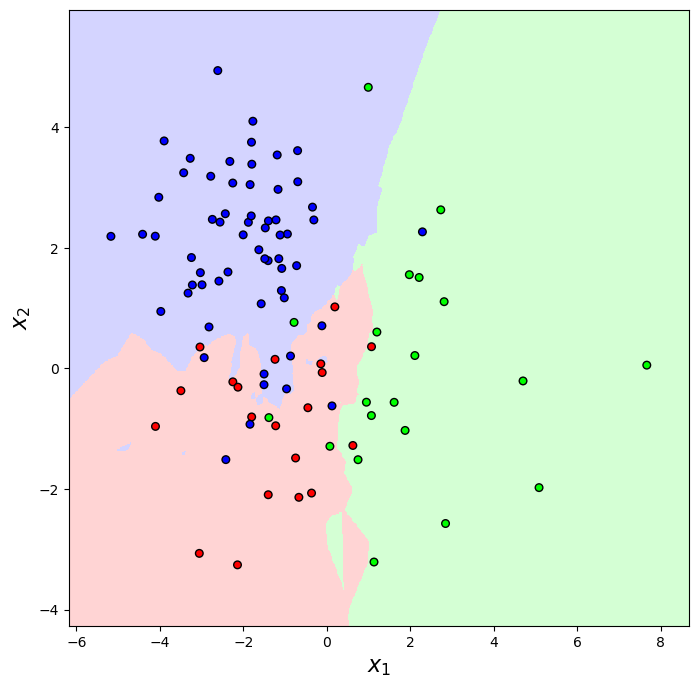

In [39]:
learn_knn_and_plot(n_neighbors=5)

## Exercise 9

### Exercise 9.1
Change the value of the hyperparameter $k$ in the cell above, and observe what happens, i.e. plot the resulting boundaries with the subsequent cell.

What is the influence of the number of neighbors on the boundaries? (Bonus points for the two extreme cases!)

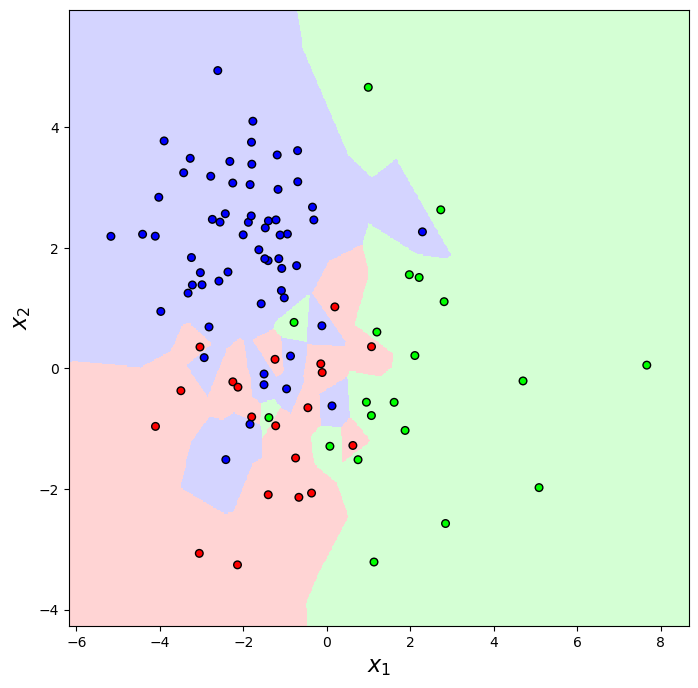

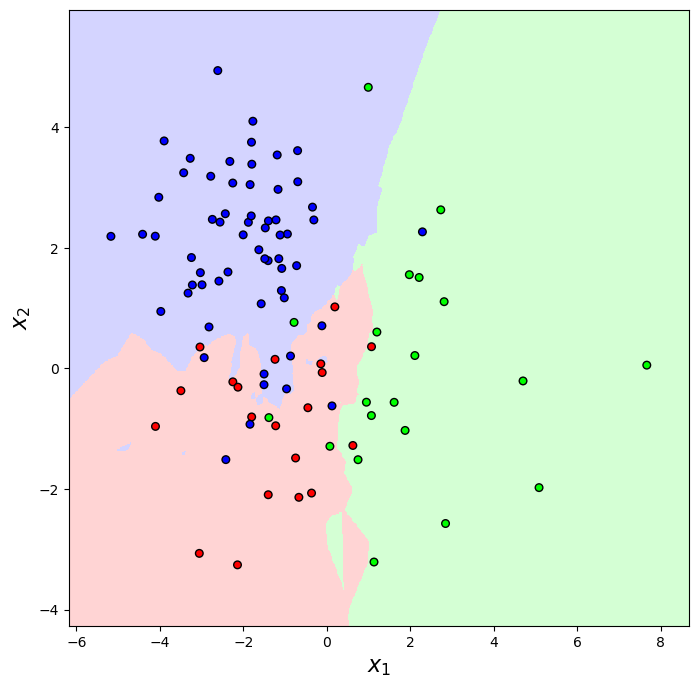

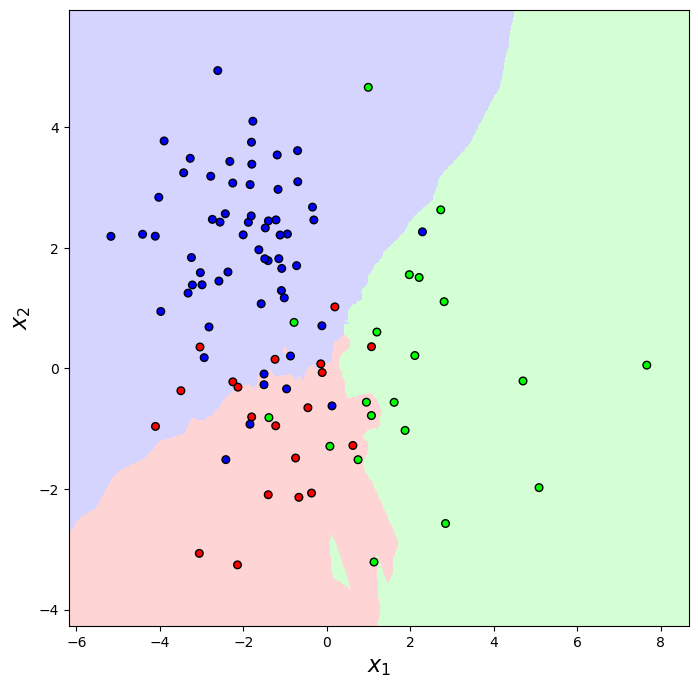

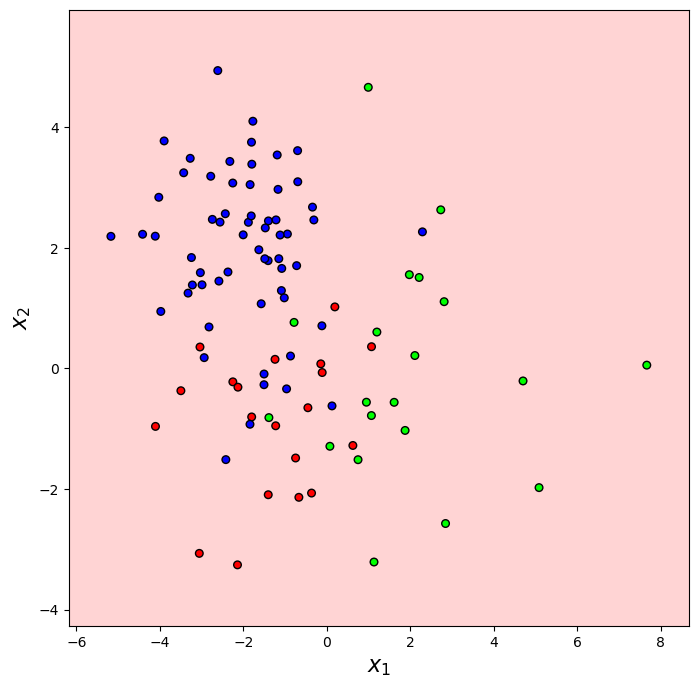

In [40]:
# learn_knn_and_plot(...)
# YOUR CODE HERE
learn_knn_and_plot(n_neighbors=1) #we notice sharp boudaries
learn_knn_and_plot(n_neighbors=5) #the boundaries are more smooth
learn_knn_and_plot(n_neighbors=20) #the boundaries are even smoother it becomes more and more general
learn_knn_and_plot(n_neighbors=100) #in extreme cases where k is equal to the total number of points the model assigns the same class 
                                    #to all points hence we observe only a red boundary

You should see that larger $k$ produce "smoother" boundaries. In general, a model with e.g. $k=5$ is less influenced by the noise contained in the dataset than a model with $k < 5$, i.e., it generalize better.

$k=1$ is 1-NN already discussed.

If $k \geq n$ (with $n$ the number of elements in the dataset $\mathcal{D}$) then all predicted points have the label of the most represented class (see question 4 in case of equals representations).

Note that the Voronoi diagram is not usefull when $k>1$. The influence of each seed now depends on $k$ and the coordinates of the others points. We cannot associate the cells' boundaries to the decision boundaries anymore.

### Exercise 9.4
Plot the decision boundary with $k=2$ (make use of the code above) and observe what happens in case of equal vote.

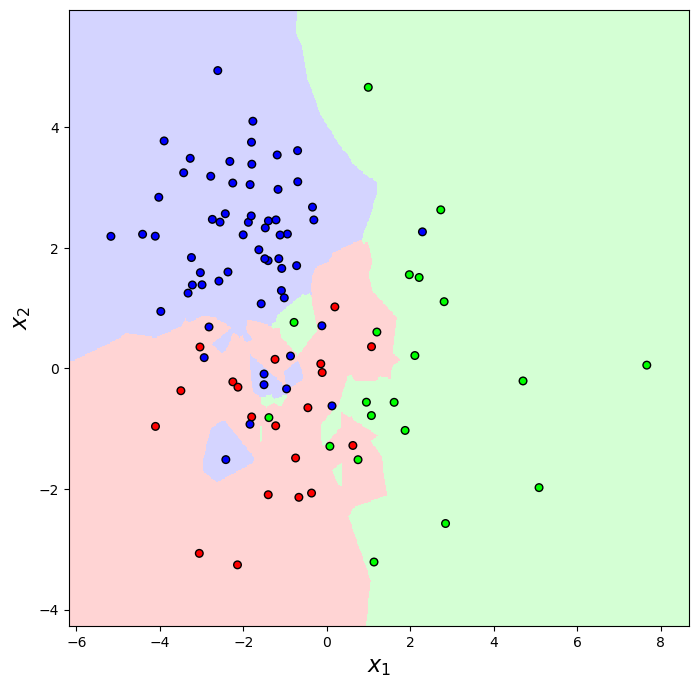

In [41]:
# learn_knn_and_plot(...)
# YOUR CODE HERE
learn_knn_and_plot(n_neighbors=2)

### Exercise 9.5
Add the `weights = "distance"` parameter in `KNeighborsClassifier`'s constructor, and repeate (again, for $k=2$).

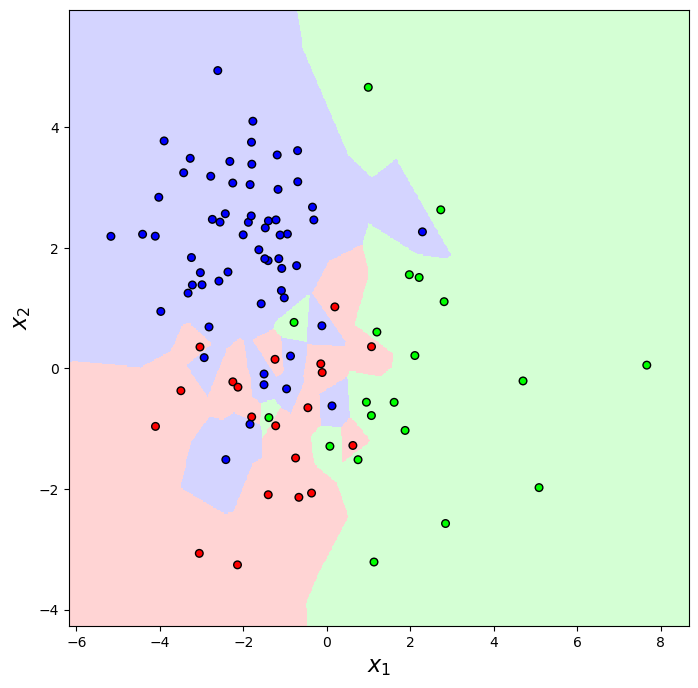

In [42]:
# learn_knn_and_plot(...)
# YOUR CODE HERE
learn_knn_and_plot(n_neighbors=2, weights="distance")

With this parameter enabled, the influence of the k nearest neighbors is weighted by their proximity to the point $\boldsymbol{x}$ to predict.

It resolves ambiguities but may make models more sensitive to the noise contained in $\mathcal{D}$.

## Regression

First we regenerate the dataset from Exercise 4 - Regression with 1-NN).

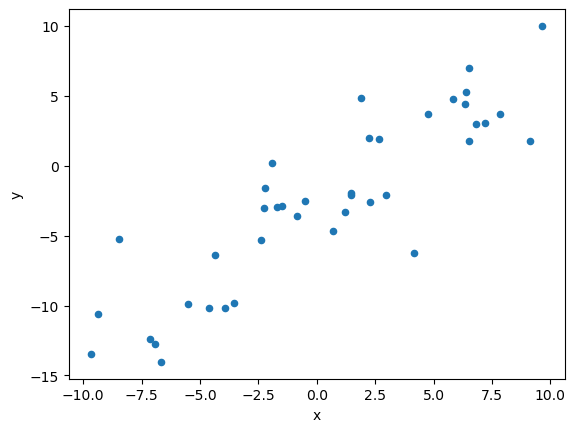

In [43]:
df = gen_and_plot_1d_regression_samples()

Then we instantiate the classifier, train it and plot the decision boundaries:

In [44]:
def train_and_plot_knn_regressor(**kwargs):
    """
    Instantiate, fits a KNN regressor and plots the training points as well as the predictions

    :param kwargs: keyword arguments passed to KNeighborsRegressor constructor
    """
    model = sklearn.neighbors.KNeighborsRegressor(**kwargs)
    model.fit(df[['x']].values, df['y'])

    x_pred = np.arange(-10, 10, 1).reshape(-1, 1)
    y_pred = model.predict(x_pred)

    df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x='x', y='y')
    df_pred.plot(x='x', y='y', style='r--', ax=ax);

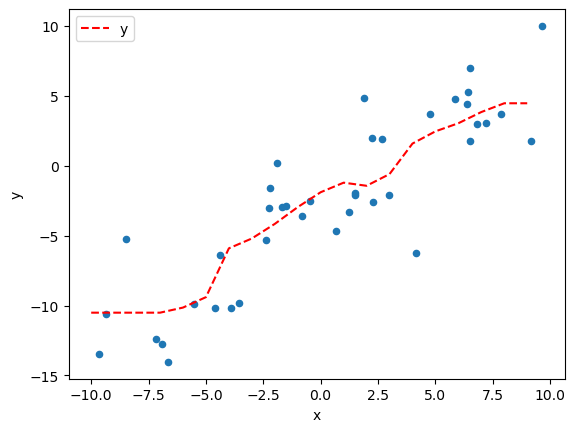

In [45]:
train_and_plot_knn_regressor(n_neighbors=10)

Now it looks much smoother; similar to the classification example, there is a **tradeoff** between high and low value of k, a **bias-variance tradeoff** that will be the subject of the next lectures. We explore this empirically in the next exercise.

## Exercise 10

*Recall*: The `n_neighbors` parameter provided to the model's constructor `KNeighborsClassifier` sets the number of neighbors to consider for each prediction (i.e. `n_neighbors` this is the '$k$' of kNN).

### Exercise 10.1

Change the value of this parameter and observe what happens.

What is the influence of the number of neighbors on the decision function?
Select what you view as a 'sensible' value for $k$ (with reasonable tradeoffs).

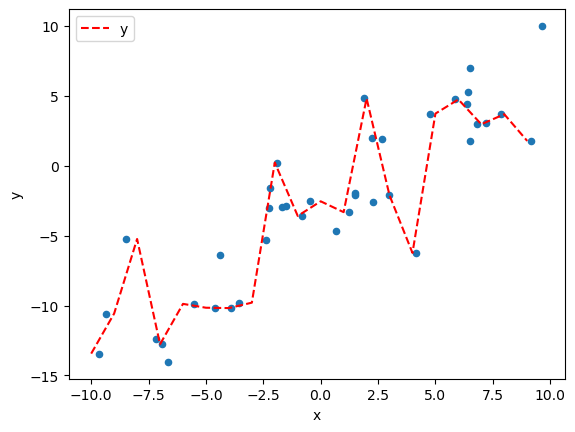

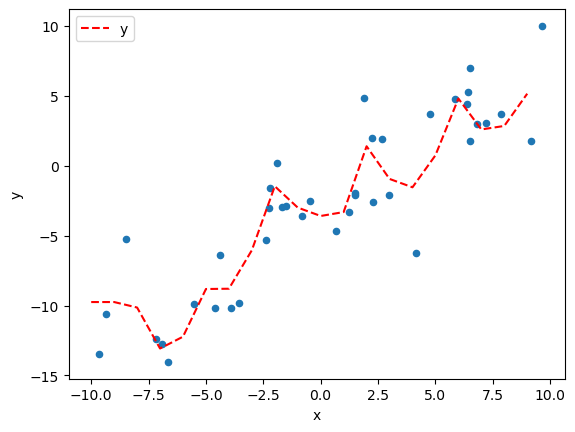

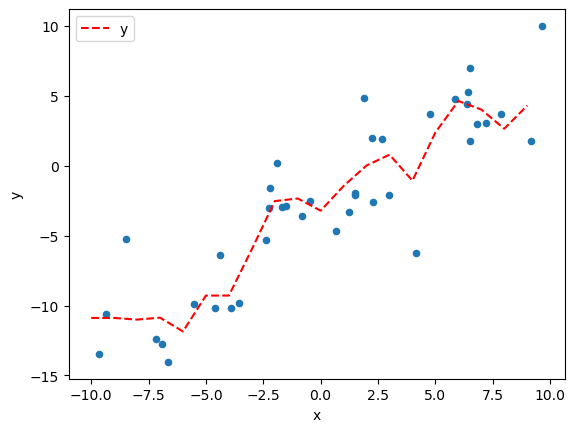

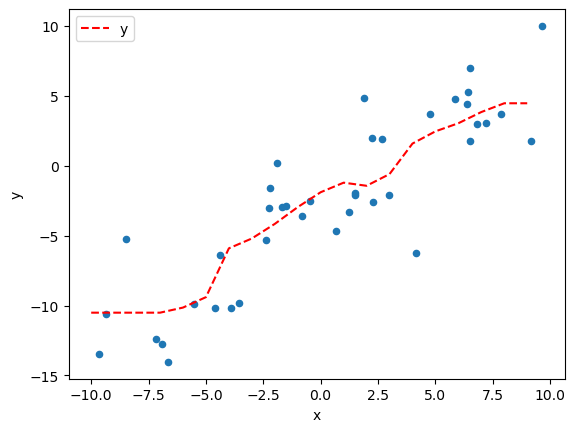

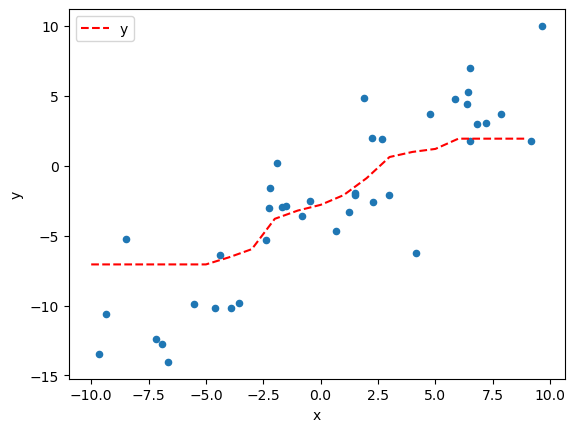

In [46]:
# train_and_plot_knn_regressor(...)
# change the value of k_sensible
k_sensible = 0
# YOUR CODE HERE
train_and_plot_knn_regressor(n_neighbors=1)  
train_and_plot_knn_regressor(n_neighbors=3)  
train_and_plot_knn_regressor(n_neighbors=5)  
train_and_plot_knn_regressor(n_neighbors=10) 
train_and_plot_knn_regressor(n_neighbors=20) 

k_sensible = 5

#we notice that a small k captures too much noise and a k that is too large gives too much of an approximation
#choosing 5 seems a good fit

Consider when faced with a very noised dataset (wrong labels, misplaced points, ...), should you increase or decrease $k$? (No answer expected)

## Exercise 11

Solve the Titanic problem with the k Nearest Neighbors method (see [`lab_session_01`](https://htmlpreview.github.io/?https://github.com/adimajo/CSE204-2021/blob/master/lab_session_01/lab_session_01.html)). Reuse the code of the first lab session:
* read the data with `read_csv`;
* select the columns useful for prediction;
* drop the missing values;
* map the categorical columns to numerical values;
* split into a training and a test subset;
* instantiate a k-NN classifier named `knn_sklearn`;
* fit the model (see previous exercises);
* compute an accuracy score (ratio of correctly predicted test points) that you store in a `score` variable. Hint: this can be computed by... the eponymous `score` function of `KNeighborsClassifier`.

In [48]:
# Replace score with your result
#score = 0
# YOUR CODE HERE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


titanic = pd.read_csv("https://raw.githubusercontent.com/ogrisel/parallel_ml_tutorial/master/notebooks/titanic_train.csv")

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X = titanic[features]
y = titanic['Survived']

# Drop rows with missing values
X = X.dropna()

# Convert categorical column 'Sex' to numerical values
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Ensure 'y' is aligned with X after dropping missing values
y = y.loc[X.index]

# Split data into training and test subsets (80% training, 20% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Instantiate and train the k-NN classifier
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train, Y_train)

# Compute the accuracy score
score = knn_sklearn.score(X_test, Y_test)
score

0.7622377622377622

## Exercise 12

Write your own implementation for the k Nearest Neighbor algorithm.
Write a `knn()` function that takes two arguments:
- `xtrain`: the observed dataset;
- `ytrain`: the observed labels;
- `xpred`: a list of examples to predict;
- `n_neighbors`: the number of nearest neighbors to use.

This function should return the sequence of predicted labels.

In [49]:
from math import sqrt


def knn(xtrain, ytrain, xpred, n_neighbors=5):
    """
    Predicts the y values of xpred given xtrain, ytrain, and n_neighbors-nn classification

    :param pandas.DataFrame xtrain: the training set's features (you can use numpy arrays as well)
    :param pandas.DataFrame ytrain: the training set's labels (you can use numpy arrays as well)
    :param pandas.DataFrame xpred: the test set's features (you can use numpy arrays as well)
    :param int n_neighbors: number of nearest neighbors to use
    """
    # So as not to mess up with the original dataframes
    xtrain_cpy = xtrain.copy()
    ytrain_cpy = ytrain.copy()
    xpred_cpy = xpred.copy()
    # Store the distances in a matrix
    distances = np.zeros((xtrain_cpy.shape[0], xpred_cpy.shape[0]))
    # Store the predictions in a vector
    ypred = np.zeros(xpred_cpy.shape[0])
    # You might want to reset the index (to have to correct row numbers)
    xtrain_cpy.reset_index(inplace=True, drop=True)
    xpred_cpy.reset_index(inplace=True, drop=True)
    
    # Compute distances of each row x in xtrain to each row x' in xpred and put it in `distances`
    # YOUR CODE HERE
    for i in range(xtrain_cpy.shape[0]):
        for j in range(xpred_cpy.shape[0]):
            diff = xtrain_cpy.iloc[i].values - xpred_cpy.iloc[j].values
            distances[i, j] = sqrt(np.sum(diff ** 2))

    # Average the labels of the `n_neighbors` closest points in xtrain of each row x in xpred
    # YOUR CODE HERE
    for j in range(xpred_cpy.shape[0]):
        nearest_indices = np.argsort(distances[:, j])[:n_neighbors]
        nearest_labels = ytrain_cpy.iloc[nearest_indices].values
        ypred[j] = np.bincount(nearest_labels.astype(int)).argmax()
    
    return(ypred)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


In [50]:
# It is assumed you defined X_train, Y_train, X_test in Exercise 11.
your_predictions = knn(X_train, Y_train, X_test)

In [51]:
# It is assumed you "trained" knn_sklearn in Exercise 11.
sklearn_predictions = knn_sklearn.predict(X_test)

Are the two predictions the same?

In [52]:
assert (your_predictions == sklearn_predictions).all()

# Computational Complexity

Think about the computational complexity of logistic regression vs kNN, in terms of `fit`ting and `predict`ing (for increasing $n$ in the training set).

Use the next cell to write some code to perform an experiment and test this to obtain more intuition.

Make use of scikit-learn implementations, fit them on a linearly growing training set (for each size, measure the time spent on `fit`ting), and test each of these fitted models on a single point (say, the first sample of training set - for each size, measure the time spent on `predict`ing).

N.B.: it could also be very interesting to compare predictive performance (e.g. accuracy).

Hint: to measure time, you can use `time.time()` at some point in your code, and then substract this value, at a later point, with the new `time.time()` to obtain a duration.

In [53]:
import time

In [54]:
sizes = list(range(100, 10001, 100))


def test(clf: sklearn.linear_model.LogisticRegression | sklearn.neighbors.KNeighborsClassifier):
    fit_times = []
    predict_times = []

    clf = sklearn.base.clone(clf)
    print(clf)
    
    for size in sizes:
        df = gen_2d_classification_samples(n_samples=size, nclass=2)
        # Call time.time()
        # Fit the classifier on df
        # Store the time it took to fit in fit_time
        # Call time.time()
        # Predict using the previously fit classifier on THE FIRST SAMPLE of df
        # Store the time it took to predict in predict_time
        # YOUR CODE HERE

        start_time = time.time()
        clf.fit(df[['x1', 'x2']].values, df['y'])
        fit_time = time.time() - start_time
        start_time = time.time()
        clf.predict(df[['x1', 'x2']].iloc[:1].values)
        predict_time = time.time() - start_time

        
        fit_times.append(fit_time)
        predict_times.append(predict_time)
    return fit_times, predict_times

lr_fit_times, lr_predict_times = test(sklearn.linear_model.LogisticRegression(penalty=None))

LogisticRegression(penalty=None)


In [55]:
knn_fit_times, knn_predict_times = test(sklearn.neighbors.KNeighborsClassifier(algorithm="brute"))

KNeighborsClassifier(algorithm='brute')


Let's represent these times on a graph w.r.t. the input size.

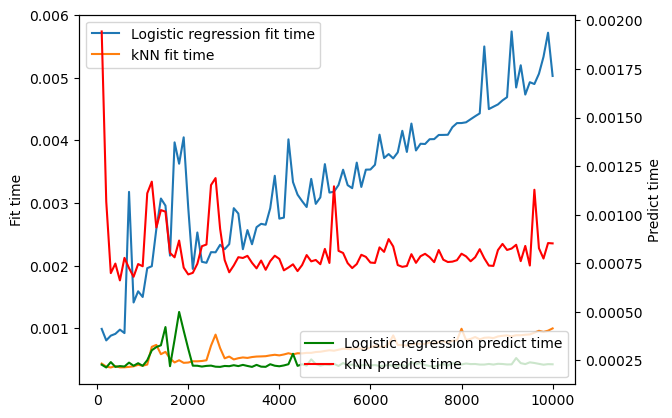

In [56]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel("Fit time")
ax2.set_ylabel("Predict time")
ax1.plot(sizes, lr_fit_times, label="Logistic regression fit time")
ax1.plot(sizes, knn_fit_times, label="kNN fit time")
ax2.plot(sizes, lr_predict_times, label="Logistic regression predict time", color='g')
ax2.plot(sizes, knn_predict_times, label="kNN predict time", color='r')
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.show()

Does this confirm your intuitions? Go back and play around with the `algorithm` argument of `KNeighborsClassifier`, see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

What relationship can we then assume (or even demonstrate!) between $n$ and `fit` (resp. `predict`) time?

Why does the `algorithm` argument of `KNeighborsClassifier` make results change that much, both in terms of `fit` and `predict`? [Hint](https://en.wikipedia.org/wiki/K-d_tree)